In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

In [2]:
from sklearn.decomposition import PCA
from os.path import join
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sn

import librosa 

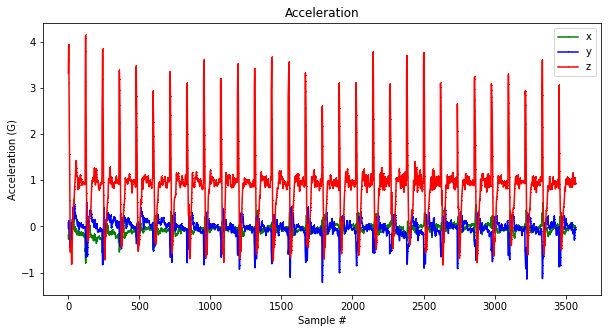

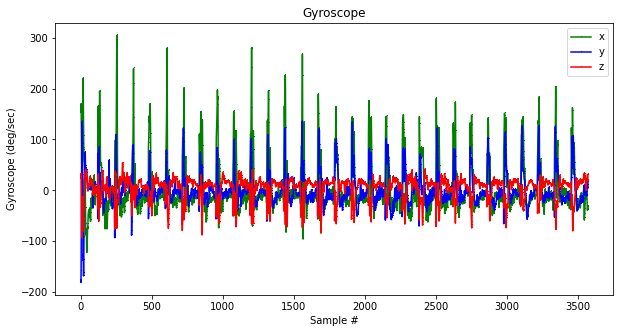

In [3]:
#PLOT DATA 
filename = "UP.csv"

df = pd.read_csv('/content/sample_data/' + filename) 


index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [6]:
max_measurements =117
raw_scale = 1 
# Function: extract specified features (variances, MAD) from sample
def extract_features(sample, max_measurements=0, scale=1):
    
    features = []
    
    # Truncate sample
    if max_measurements == 0:
        max_measurements = sample.shape[0]
    sample = sample[0:max_measurements]
    
    # Scale sample
    sample = scale * sample
    
    # Median absolute deviation (MAD)
    features.append(stats.median_abs_deviation(sample))
     
    return np.array(features).flatten()

In [8]:

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
# "Reproducibility" means the ability to run the same thing twice and get 
#the same results.

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "RIGHT",
    "UP",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  starting_sample = 0 
  End_sample = 119
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/sample_data/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    Wave = df.iloc[starting_sample:End_sample,:]  
    Wave = Wave.to_numpy()
    features = extract_features(Wave, max_measurements, scale=raw_scale)
    starting_sample = starting_sample + 119
    End_sample = End_sample + 119
    inputs.append(features)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)
print( inputs.shape )
print( outputs.shape )


Processing index 0 for gesture 'RIGHT'.
	There are 44 recordings of the RIGHT gesture.
Processing index 1 for gesture 'UP'.
	There are 30 recordings of the UP gesture.
(74, 6)
(74, 2)


In [9]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_train.shape)
print(inputs_validate.shape)
print(outputs_train.shape)
print(outputs_validate.shape)

Data set randomization and splitting complete.
(44, 6)
(16, 6)
(44, 2)
(16, 2)


In [10]:
# Get input shape for 1 sample
sample_shape = inputs.shape[1:]
print(sample_shape)

(6,)


In [19]:
# Build model
encoding_dim = 2       # Number of nodes in first layer
model = models.Sequential([
    layers.InputLayer(input_shape=sample_shape),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_GESTURES, activation='softmax')
])

# Display model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 2)                 14        
                                                                 
 dense_8 (Dense)             (None, 20)                60        
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 42        
                                                                 
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Add training parameters to model
model.compile(optimizer='adam',
             loss='mse')
# Train model (note Y labels are same as inputs, X)
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/600
44/44 [==============================] - 1s 5ms/step - loss: 0.1061 - val_loss: 0.0311
Epoch 2/600
44/44 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.0166
Epoch 3/600
44/44 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0126
Epoch 4/600
44/44 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0054
Epoch 5/600
44/44 [==============================] - 0s 3ms/step - loss: 0.0308 - val_loss: 0.0044
Epoch 6/600
44/44 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0041
Epoch 7/600
44/44 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0037
Epoch 8/600
44/44 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0032
Epoch 9/600
44/44 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0014
Epoch 10/600
44/44 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0024
Epoch 11/

1/1 [==============================] - 0s 68ms/step
predictions =
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
actual =
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


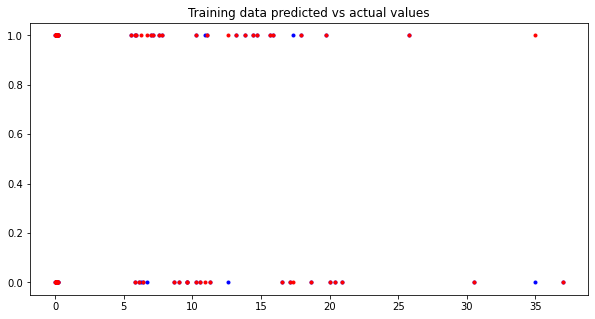

In [21]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

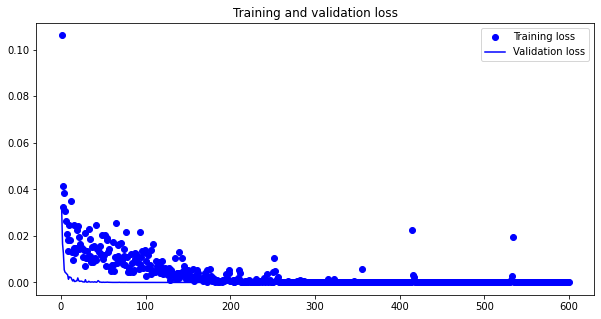

In [22]:
# Plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 2520 bytes


In [24]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 15,574 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
